In [1]:
import os
from time import time, strftime, gmtime
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mne import Epochs, find_events
from mne.time_frequency import psd_welch
from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from experiments import steadyStateEvokedPotentials
from dataset import brainflowDataset
from utils import plot_conditions, SYNTHETIC_CHANNELS

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# SSVEP

The steady-state visual evoked potential (SSVEP) is a repetitive evoked potential that is naturally produced when viewing stimuli flashing between a range of 6-75hz. Electrical activity at the same frequency as the visual stimulation can be detected in the occipital areas of the brain, likely due to the perceptual recreation of the stimulus in the primary visual cortex.

The SSVEP is often used in BCI applications due to its ease of detection and the amount of information that a user can communicate due to the high potential frequency resolution of the SSVEP.

In this notebook, we will use the Muse EEG headband with an extra occipital electrode to detect the SSVEP and evaluate it's use in SSVEP-based BCIs.


<img src="https://eeg-notebooks.readthedocs.io/en/latest/_images/attaching_electrode.png" style="height: 300px; float: right"/>
## Extra Electrode

Although the SSVEP is detectable at the default temporal electrodes, it can be seen much more clearly directly over the occipital cortex.

The Muse 2016 supports the addition of an extra electrode which can be connected through the devices microUSB charging port.

- [Instructions on how to build an extra electrode for Muse](http://forum.choosemuse.com/t/step-by-step-tutorial-for-making-muse-auxilliary-channel-electrode/3172?u=tttz)
- [Working with the extra electrode](https://eeg-notebooks.readthedocs.io/en/latest/using_an_extra_electrode_muse.html)

For this experiment, the extra electrode should be placed at POz, right at the back of the skull. It can be secured in place with a bandana or a hat

## Set up the experiment

In [2]:
ssvep_exp = steadyStateEvokedPotentials()

## Initialize the EEG signal

In [3]:
# For tresting without connection
ssvep_exp.initialize_eeg(board_type='synthetic')

# For using the 8-channel Cyton board
#ssvep_exp.initialize_eeg(board_type='cyton')

# For using the 16-channel Cyton+Daisy combo
#ssvep_exp.initialize_eeg(board_type='daisy')

## Run Experiment

In [4]:
subject_name = 'test_subject'
duration = 120
trial_num = 2
ssvep_exp.run_trial(duration=duration,
                    subject=subject_name,
                    run=trial_num)

Beginning EEG Stream; Wait 5 seconds for signal to settle... 

[{'cycle': (2, 2), 'freq': 50.0, 'n_cycles': 75.0}, {'cycle': (3, 3), 'freq': 33.333333333333336, 'n_cycles': 50.0}]
data/test_subject_ssvep_2_EVENTS.csv


## Load the Dataset

In [2]:
subject_name = 'test_subject'
runs = [2]
dataset_ssvep = brainflowDataset(paradigm='ssvep', subject=subject_name, board_type='synthetic')
raw = dataset_ssvep.load_subject_to_raw(subject_name, runs, preprocess=False)

data/test_subject_ssvep_2.csv
Creating RawArray with float64 data, n_channels=8, n_times=30055
    Range : 0 ... 30054 =      0.000 ...   117.398 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=30055
    Range : 0 ... 30054 =      0.000 ...   117.398 secs
Ready.


## Filter the data and view PSD
One way to analyze the SSVEP is to plot the power spectral density, or PSD. SSVEPs should appear as peaks in power for certain frequencies. We expect clear peaks in the spectral domain at the stimulation frequencies of 30 and 20 Hz.
The justification for filtering 1-45 Hz is taken from... [**Find reference from Riemannian Geometric Classifier paper**]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 55.00 Hz: -6.02, -6.02 dB

Effective window size : 8.000 (s)


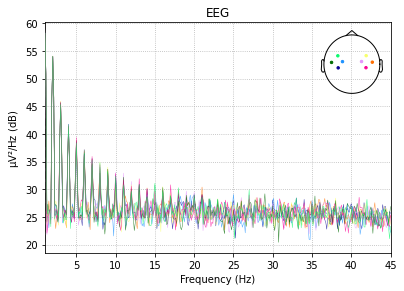

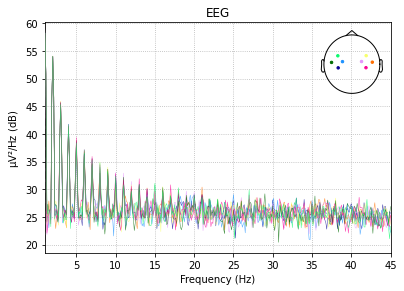

In [3]:
raw.filter(1, 55, method='iir')
raw.plot_psd(fmin=1, fmax=45)

## Epoching

Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus.

*Note: we will not reject epochs here because the amplitude of the SSVEP at POz is so large it is difficult to separate from eye blinks*

In [4]:
events = find_events(raw)
event_id = {'50 Hz': 1, '33 Hz': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.5, tmax=4, baseline=None, preload=True,
                verbose=False)
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

23 events found
Event IDs: [1 2]
sample drop %:  8.695652173913048


### Stimuli-Specific PSD

Next, we can compare the PSD of epochs specifically during 20hz and 30hz stimulus presentation

Effective window size : 4.016 (s)
Effective window size : 4.016 (s)


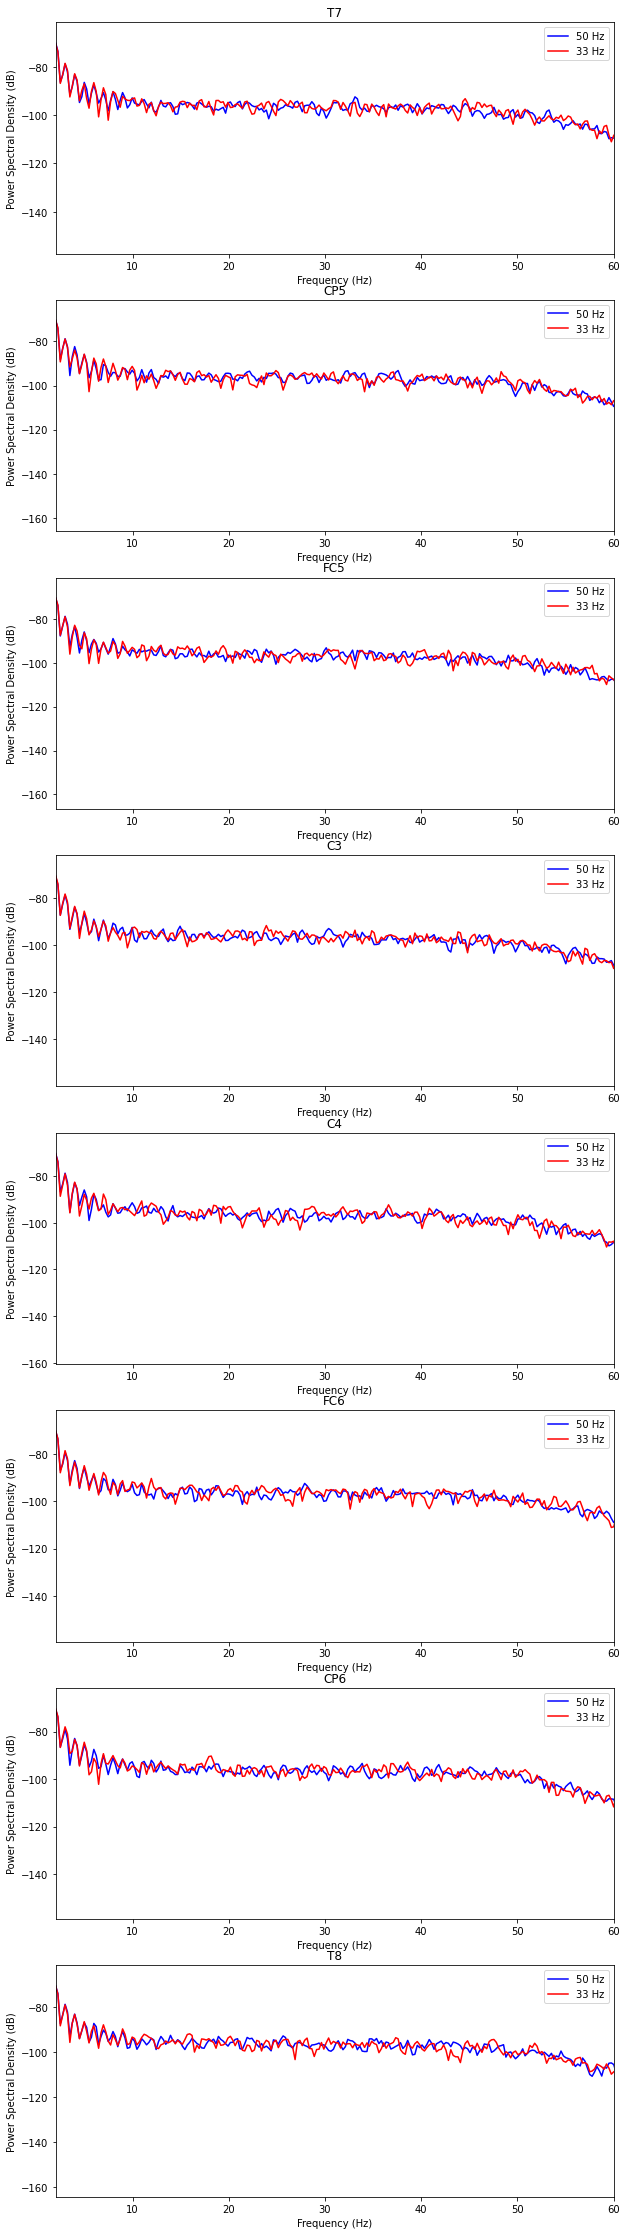

In [9]:
psd1, freq1 = psd_welch(epochs['50 Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['33 Hz'], n_fft=1028, n_per_seg=256 * 3)
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)
psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)

psd2_mean = psd2.mean(0)
psd2_std = psd2.mean(0)

num_channels = psd1.shape[1]
f, axs = plt.subplots(num_channels, 1, figsize=(10, num_channels*5))
for i in range(num_channels):
    axs[i].plot(freq1, psd1_mean[i, :], color='b', label='50 Hz')
    axs[i].plot(freq2, psd2_mean[i, :], color='r', label='33 Hz')
    axs[i].set_title(SYNTHETIC_CHANNELS[i])
    axs[i].set_ylabel('Power Spectral Density (dB)')
    axs[i].set_xlim((2,60))
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].legend()

plt.show()



With this visualization we can clearly see distinct peaks at 30hz and 20hz in the PSD, corresponding to the frequency of the visual stimulation. The peaks are much larger at the POz electrode, but still visible at TP9 and TP10

### Spectrogram
We can also look for SSVEPs in the spectrogram, which uses color to represent the power of frequencies in the EEG signal over time

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


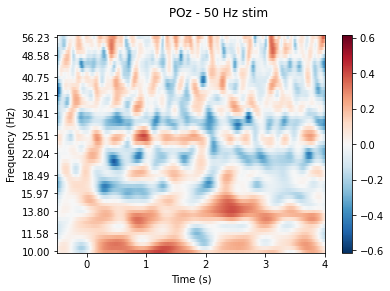

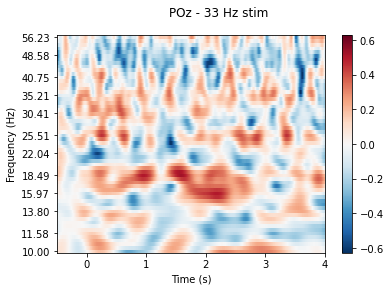

In [11]:
from mne.time_frequency import tfr_morlet

frequencies = np.logspace(1, 1.75, 60)
tfr, itc = tfr_morlet(epochs['50 Hz'], freqs=frequencies,
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - 50 Hz stim');

tfr, itc = tfr_morlet(epochs['33 Hz'], freqs=frequencies,
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - 33 Hz stim');

Once again we can see clear SSVEPs at 30hz and 20hz

### Decoding

We can use a filter bank approach on the original 4 Muse electrodes (to see how the headband alone without external electrodes could be used to classify SSVEP):

1. Apply bandpass filters around both stimulation frequencies
2. Concatenate bandpass-filtered channels
2. Extract epochs (from 1 to 3 s after stimulus onset, to avoid classifying the ERP)
3. Apply common classification pipelines

In [12]:
# Bandpass filter the raw data
raw_filt_50Hz = raw.copy().filter(45, 55, method='iir')
raw_filt_33Hz = raw.copy().filter(25, 40, method='iir')
raw_filt_50Hz.rename_channels(lambda x: x + '_50Hz')
raw_filt_33Hz.rename_channels(lambda x: x + '_33Hz')

# Concatenate with the bandpass filtered channels
raw_all = raw_filt_50Hz.add_channels([raw_filt_33Hz],
                                    force_update_info=True)

# Extract epochs
events = find_events(raw_all)
event_id = {'50 Hz': 1, '33 Hz': 2}

epochs_all = Epochs(raw_all, events=events, event_id=event_id, tmin=1, 
                     tmax=3, baseline=None, reject={'eeg': 100e-6}, 
                     preload=True, verbose=False,)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 45 - 55 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 45.00, 55.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 25.00, 40.00 Hz: -6.02, -6.02 dB

23 events found
Event IDs: [1 2]
23 events found
Event IDs: [1 2]


<ipython-input-12-3c425525834a>:12: RuntimeWarning: Some events are duplicated in your different stim channels. 23 events were ignored during deduplication.
  events = find_events(raw_all)


In [13]:
epochs_all.pick_types(eeg=True)
X = epochs_all.get_data() * 1e6
times = epochs.times
y = epochs_all.events[:, -1]

### Decoding the N170

Next, we will use 4 different machine learning pipelines to classify the SSVEP based on the data we collected. The 

- **CSP + RegLDA** :  Common Spatial Patterns + Regularized Linear Discriminat Analysis. This is a very common EEG analysis pipeline.
- **Cov + TS** :  Covariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipelines.
- **Cov + MDM**: Covariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.
- **CSP + Cov + TS**: Common Spatial Patterns + Covariance + Tangent spacem mapping. Riemannian pipeline with the standard CSP procedure beforehand

Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

*Note: because we're doing machine learning here, the following cell may take a while to complete*

In [18]:
clfs = OrderedDict()

clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='eigen'))
clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())
clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())
clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression())

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        print('exception')
        pass
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

CSP + RegLDA
exception
Cov + TS
exception
Cov + MDM
exception
CSP + Cov + TS
exception


In [15]:
fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 1)
sns.despine()

ValueError: min() arg is an empty sequence

<Figure size 576x288 with 0 Axes>

The different classifiers get some impressive accuracy on this dataset, all around .95 AUC. This is impressive considering this pipeline only included data from the temporal electrodes